# Machine Learning in Python - Group Project 2


Contributors:
* Thomas Lanning
* Alexander Bohane
* Mengyao Zhang
* Shangyun Sun

## 1. Introduction

Dear Client, 

In this report, we have analyzed the data provided about hotel cancellations to better understand what factors drive the cancellations of bookings. The main aim here is to provide an accurate model to predict booking cancellations, but also demonstrating what factors of a booking affect the probability of it being cancelled. 

To do this task, we will be using understandable and validated models that are both accurate and reliable. Since we also want to rank the importance of different factors, we will not be making any black box models. We want to be able to visualize our model to some extent for you, so you have a deeper understanding of what is going on and how we drew our conclusions. 

Before we start modelling, we will start with an extensive analysis of the data to see what data is missing, incorrect or nonsensical. We will visualize the data for you to understand patterns, correlations and other aspects.

After we understand the data better, we can develop a model to predict the cancellation rate. In this report we have chosen a logistic regression model. This is done because it is not a black box and produces excellent predictions. In addition, it provides a flexibility for setting a prediction threshold, allowing you to choose a setting to determine the trade-off between the false positives and false negatives. This either prevents overbooking rooms or underbooking rooms.

Our model predicts that the most important features are `previous cancellations` for cancelled prediction and `required car parking spaces` for a not cancelled prediction. In addition, we warn against the importance of some feature importances. Our model selects Portugese people as being an important factor in booking cancellations. However, we suggest careful consideration of AI ethics before you make any decisions upon this model. It would not be right to discriminate a countries people based on this. 

The predictions of the model will be highlighted in economic terms for the hotel. Other models were tried and neglected. These include black box models, decision trees, ridge regression classifier, etc. This is because economically, we want to minimize the false positives and flase negatives, leading to specific scores we chose to prioritize over others. Further discussions will be found throughout the report, and our full discussion with conclusion at the end of this report. 

## General Setup

We will import all the necessary libraries for this analysis

In [1]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np
import calendar

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

In [47]:
# Load data
d = pd.read_csv("hotel.csv")

## 2. Exploratory Data Analysis and Feature Engineering

### 2.1 Exploratory Data Analysis

First we will explore the given dataset and clean the abnormal data. We find that the data is quite messy and needs a lot of cleaning:

#### 2.1.1 Data Overview

First, lets look at what the data looks like:

In [4]:
d.head(1)

is_canceled         hotel  lead_time  arrival_date_year arrival_date_month  \
0            0  Resort Hotel        342               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        0                     0       2  ...   

   assigned_room_type  booking_changes deposit_type agent company  \
0                   C                3   No Deposit   NaN     NaN   

  days_in_waiting_list  customer_type  adr  required_car_parking_spaces  \
0                    0      Transient  0.0                            0   

  total_of_special_requests  
0                         0  

[1 rows x 30 columns]

The columns/features of the data set are listed below, as well as the number of entries per feature and whether that feature is continuous, discrete or categorical. 

In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119390 non-null  int64  
 1   hotel                           119390 non-null  object 
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

As we can see from the above, there are 119390 bookings with 30 features. Our target variable is the feature: `is_canceled` which takes on a value of 1 if a booking is canceled or 0 if a booking is **NOT** canceled
 
Four features `children`, `country`, `agent`, and `company` have 'NULL' values. However, the 'NULL' in `agent` and `company` should not be considered as missing values. It is more likely to represent 'not applicable'. For example, a booking with 'NULL' `agent` means that this booking is not from a travel agent, but rather could be done individually. So we will regard 'NULL' in `agent` and `company` as a new category.

It is worth noting that the data type of `agent` and `company` is given as a float, but this actually represents their company IDs, so they should be regarded as categorical variables.

Now we will look at the descriptive statistics of our data.

In [6]:
display(d.describe().T.round(2))

count     mean     std      min      25%  \
is_canceled                     119390.0     0.37    0.48     0.00     0.00   
lead_time                       119390.0   104.01  106.86     0.00    18.00   
arrival_date_year               119390.0  2016.16    0.71  2015.00  2016.00   
arrival_date_week_number        119390.0    27.17   13.61     1.00    16.00   
arrival_date_day_of_month       119390.0    15.80    8.78     1.00     8.00   
stays_in_weekend_nights         119390.0     0.93    1.00     0.00     0.00   
stays_in_week_nights            119390.0     2.50    1.91     0.00     1.00   
adults                          119390.0     1.86    0.58     0.00     2.00   
children                        119386.0     0.10    0.40     0.00     0.00   
babies                          119390.0     0.01    0.10     0.00     0.00   
is_repeated_guest               119390.0     0.03    0.18     0.00     0.00   
previous_cancellations          119390.0     0.09    0.84     0.00     0.00   
previous_bookings_not_canceled  119390.0     0.14    1.50     0.00     0.00   
booking_changes                 119390.0     0.22    0.65     0.00     0.00   
agent                           103050.0    86.69  110.77     1.00     9.00   
company                           6797.0   189.27  131.66     6.00    62.00   
days_in_waiting_list            119390.0     2.32   17.59     0.00     0.00   
adr                             119390.0   101.83   50.54    -6.38    69.29   
required_car_parking_spaces     119390.0     0.06    0.25     0.00     0.00   
total_of_special_requests       119390.0     0.57    0.79     0.00     0.00   

                                    50%     75%     max  
is_canceled                        0.00     1.0     1.0  
lead_time                         69.00   160.0   737.0  
arrival_date_year               2016.00  2017.0  2017.0  
arrival_date_week_number          28.00    38.0    53.0  
arrival_date_day_of_month         16.00    23.0    31.0  
stays_in_weekend_nights            1.00     2.0    19.0  
stays_in_week_nights               2.00     3.0    50.0  
adults                             2.00     2.0    55.0  
children                           0.00     0.0    10.0  
babies                             0.00     0.0    10.0  
is_repeated_guest                  0.00     0.0     1.0  
previous_cancellations             0.00     0.0    26.0  
previous_bookings_not_canceled     0.00     0.0    72.0  
booking_changes                    0.00     0.0    21.0  
agent                             14.00   229.0   535.0  
company                          179.00   270.0   543.0  
days_in_waiting_list               0.00     0.0   391.0  
adr                               94.58   126.0  5400.0  
required_car_parking_spaces        0.00     0.0     8.0  
total_of_special_requests          0.00     1.0     5.0

From the above we can infer:
* The ranges of date (including `arrival_date_year`, `arrival_date_week_number` and `arrival_date_day_of_month`) are all reasonable.
* The minimum value of `adr`(Average Daily Rate) is negative (-6.38), which is impossible, so the bookings with negative `adr` should be cleaned from our data. 
* The minimum values of `adults` and `children` are 0. We should make sure that for each booking, the total number of `adults` and `children` is not 0. 

#### 2.1.2 Data Cleaning

Now that we have explored the data, it is imperative that we clean the data before making further analysis.

Firstly, we will create a new category for 'NULL' in `agent` and `company`, and call it a `0` category

In [48]:
d['agent'] = d['agent'].fillna(0)
d['company'] = d['company'].fillna(0)

We will also replace 'Undefined' with 'SC' in `meal` because we find that they have the same meaning from the table 'Description of Vaviables' from the instruction document. 

In [49]:
d.loc[d['meal'] == 'Undefined', 'meal'] = 'SC'

We replace 'Undefined' in other features with NaN, since they don't have specific interpretable meanings so can be treated as actual missing values.

In [50]:
d.replace('Undefined', np.nan, inplace = True)

Now we want to see how many missing values we have in our total dataset.

In [51]:
null = d.isnull().sum()
null[null.values != 0]

children                  4
country                 488
market_segment            2
distribution_channel      5
dtype: int64

The largest possible proportion of missing values in whole dataset is 499/119390, which is a very small percentage of the total sample. Therefore, we can delete any booking from our dataset that has any feature missing incomplete data. We consider for future improvements to use data imputation to fill the data (for example with nearest neighbors).

In [52]:
d = d.dropna()
len(d)

118897

Now the abnormal data is cleaned. As we determined beforehand, negative `adr` should be eliminated:

In [53]:
d = d[d['adr'] >= 0]
len(d)

118896

The length of our data only decreases by 1, which indicates that there is only 1 false `adr` data. This is most likely a manual error in the entry of the data. 

Then we consider the number of people (adults and children). Some bookings have no adult and no child, we believe that those bookings are also the result of incorrect data entry so we drop these entries from our dataset.

In [54]:
d.drop(d[d.adults + d.children == 0].index, inplace = True)
len(d)

118726

Finally, we consider whether our data have **duplicates**. Bookings in our data don't have unique identifiers like order numbers, so it is hard to tell whether there is a duplicate. Even if two bookings have the same values for all features, there is no way to distinguish between the two. Therefore, we won't delete any bookings even if we suspect that they may be duplicates as we cannot be fully confident. 

Finally, we convert the data type of `agent` and `company` into 'object', in order to easily seperate the numerical and categorical features by their types.

In [55]:
d[['agent', 'company']] = d[['agent', 'company']].astype(int).astype(str)

#### 2.1.3 Numerical Features Analysis

Now we focus on the numerical features. 

In [12]:
num_data = d.select_dtypes(include = ['int', 'float'])
num_data.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')

The correlation between these features is shown below.

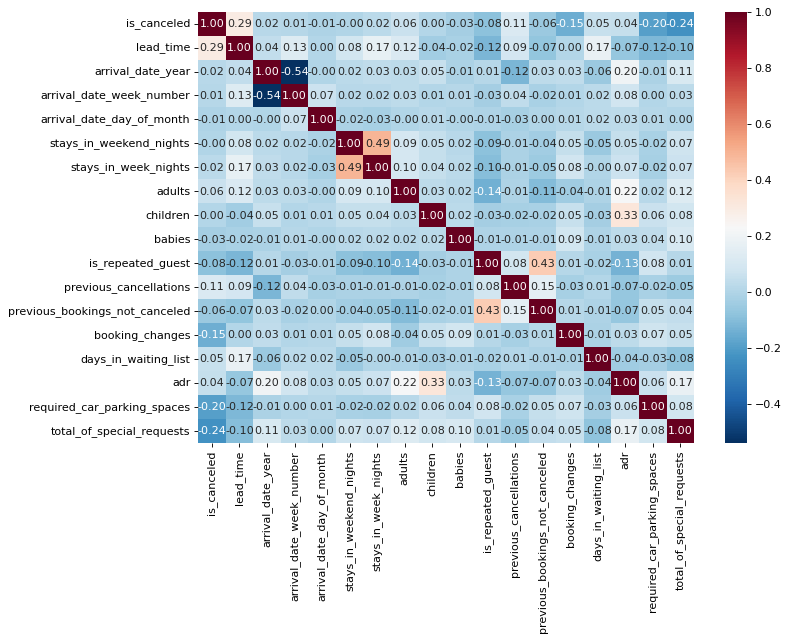

In [16]:
corr = num_data.corr()
sns.set_context({'figure.figsize': [10,7]})
sns.heatmap(corr,cmap = 'RdBu_r', annot = True, fmt = '.2f')
plt.show()

We can find:
* If we focus on the first line, we can see the correlation between `is_canceled` and other features. 
  * `lead_time` has the largest positive correlation (0.29) with `is_canceled`, which means that the earlier a booking is made, the more likely it is to be cancelled. 
  * `previous_cancellations` has the second largest positive correlation with `is_canceled`, which indicates that the more a guest has precious cancelled bookings, the more he is likely to cancel the new booking.
  * `total_of_special_requests` has the largest negative correlation (-0.24). It indicates that the more special requests a booking has, the less likely it is to be cancelled.
  * `required_car_parking_spaces` and `booking_changes` have relatively large negative correlations with `is_canceled`. It seems that the bookings with specific requirements (like car parking spaces, further changes and other special requests) reflect the willingness of the customers to go to the hotel, and not cancel their bookings.
* `arrival_date_year` and `arrival_date_week_number` have the highest correlation among all pairs. However, as the years of our data are too far away from the present, we consider that for the prediction of future cancellation, it is not meaningful to study `arrival_date_year` in the data.
* Customers who have previous bookings that are not cancelled are more likely to book repeatedly.

Since the purpose of the project is to understand why customers cancel their reservations, we then focus on the influence of features which have high correlation with `is_canceled`. For convenience, we define a function to calculate the cancellation rate of different values in one feature.

In [13]:
def cancel_by_group(d, feature_name):
    
    # all values in this feature
    name_list = d[feature_name].drop_duplicates().values
    total = []   # the total number of bookings
    cancel = []  # the number of cancelled bookings
    for name in name_list:
        total.append(len(d[d[feature_name] == name]))
        cancel.append(len(d[(d[feature_name] == name) & (d['is_canceled'] == 1)]))
    cancel_rate = [round(a / b, 2) for a, b in zip(cancel, total)]  # calculate the cancellation rate
    feature_cancel = pd.DataFrame({feature_name: name_list, 'total_booking': total, 
                               'cancellation_rate': cancel_rate})
    sort_value = feature_cancel.sort_values(by = ['total_booking'], ascending = False)
    return sort_value

**lead_time**

Below is a graph that shows the cancellation rate against lead time

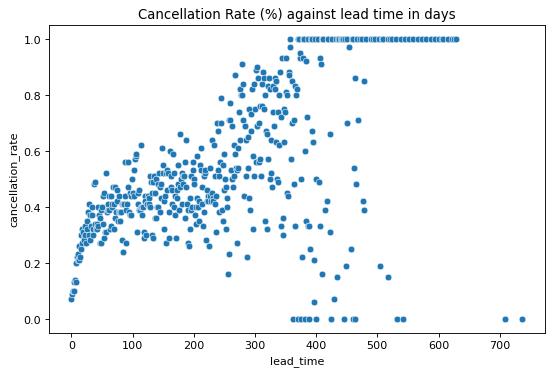

In [18]:
lt_c = cancel_by_group(num_data, 'lead_time').sort_values(by = ['lead_time'])
sns.set_context({'figure.figsize': [8,5]})
sns.scatterplot(x = 'lead_time', y = 'cancellation_rate', data = lt_c)
plt.title("Cancellation Rate (%) against lead time in days")
plt.show()

The plot tells:
* When `lead_time` lies within around [0, 100] days, we can find a clear upward trend, which means that the cancellation rate rises as the number of days booked in advance increases.
* When `lead_time` lies within around [100, 200], there is no clear trend. By observation, we find that the cancellation rate fluctuates between approximately 0.2 and 0.6. And as the value of lead_time exceeds 200, the fluctuation range increases with lead_time increasing.
* When the value of `lead_time` exceeds 500, most of the cancellation rate is either 0 or 1, perhaps because the total number of bookings is too small, and these results are not generalized.

Now lets move on to the next variable:

**total_of_special_requests**

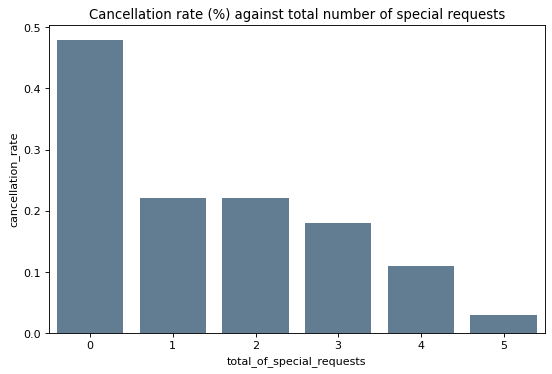

In [19]:
req_c = cancel_by_group(num_data, 'total_of_special_requests').sort_values(by = ['total_of_special_requests'])
sns.barplot(x = 'total_of_special_requests', y = 'cancellation_rate', data = req_c, color = sns.xkcd_rgb['steel blue'])
plt.title("Cancellation rate (%) against total number of special requests")
plt.show()

The plot tells that nearly a half of bookings without special requests will be cancelled later. If a booking has special requests, there will be an obvious drop in cancellation rate. Besides, if a booking has more than 3 special requests, the probability of cancellation will be even lower.

**required_car_parking_spaces**

In [20]:
cancel_by_group(num_data, 'required_car_parking_spaces').sort_values(by = ['required_car_parking_spaces'])

required_car_parking_spaces  total_booking  cancellation_rate
0                            0         111424                0.4
1                            1           7269                0.0
2                            2             28                0.0
4                            3              3                0.0
3                            8              2                0.0

It is quite remarkable that the cancellation rate of bookings with a requirement for >1 car parking spaces is 0. This feature will be useful when we predict whether a booking will be cancelled, even if such bookings only account for 6.15% of the total bookings. We will expect this feature to be of great importance in our model.

**booking_changes**

From the descriptive statistics of `booking_changes`, we know that it has a discrete distribution with several values. We want to select values with enough data (`total_booking` > 100) first, since the results drawn from too few data points cannot be generalized. `total_booking` > 100 is an arbitrary threshold we set for which higher values are more significant and vice versa.

In [21]:
# lets repeat the previous process to see how many times does a booking code change?
bc_c = cancel_by_group(num_data, 'booking_changes').sort_values(by = ['booking_changes'])
bc_c_d = bc_c[bc_c['total_booking'] > 100]
sum(bc_c_d['total_booking'])/sum(bc_c['total_booking'])

0.9988545053316039

The bookings with the specified number of changes account for ~99% of all bookings. The further analysis based on them is tenable.

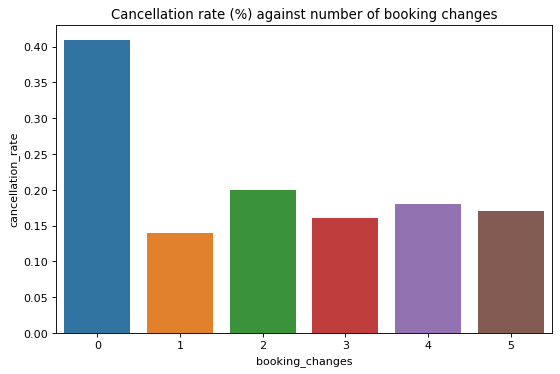

In [22]:
sns.barplot(x = 'booking_changes', y = 'cancellation_rate', data = bc_c_d)
plt.title("Cancellation rate (%) against number of booking changes")
plt.show()

There is a large gap in cancellation rate between bookings without any changes (around 40%) and bookings with changes (around 18%). As long as a customer changes their booking, they are much less likely to cancel it.

From the analysis of `total_of_special_requests`, `required_car_parking_spaces` and `booking_changes`, we can conclude that if a customer has specific requirements on the booking, including special requests, car parking spaces and any further changes on the current booking, they are strongly willing to go to the hotel as they have put in time and effort to detail their requirements so that the hotel can accomodate their needs. Therefore, there is a low risk of cancellation for such type of bookings. It is likely that such bookings have many moving parts, with other aspects of the trip being planned in conjunction with the hotel booking. This reduces the likelihood of cancellation. 


#### 2.1.4 Categorical Features

We then focus on categorical features, which is important for feature engineering.

In [34]:
# extract columns of categorical features by dtype = object
cg_data = d.select_dtypes(include = ['object'])

# extract the names of all categorical features
cg_features = cg_data.columns

# add is_canceled to the data for convenience for further analysis
cg_data = pd.concat([cg_data, pd.DataFrame({'is_canceled': d['is_canceled']})], axis = 1)

In [15]:
cg_features

Index(['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'agent', 'company', 'customer_type'],
      dtype='object')

There are 12 categorical features in our dataset. We have examined them all. Below we will present the most relevant categorical features that logically may carry the most influence in our modelling process



**Hotel Type**

There are two hotels in our data, which are City Hotel and Resort Hotel. The number of bookings and cancellation rate of each of them are shown in the following table.

In [16]:
cancel_by_group(cg_data, 'hotel')

hotel  total_booking  cancellation_rate
1    City Hotel          79143               0.42
0  Resort Hotel          39583               0.28

We can find that City Hotel has more bookings, roughly twice as many as Resort Hotel. Besides, there is a significant difference in cancellation rate. City Hotel has a much higher cancellation rate (42%) than Resort Hotel (28%).

Due to the obvious difference between these two hotels, we want to investigate other features based on the type of hotel. For numerical features, we can roughly see their means and try to find the characteristics of each hotel. 

In [17]:
data_hotel = d.groupby('hotel').mean()
data_hotel.drop(['arrival_date_year','arrival_date_week_number','arrival_date_day_of_month'], axis = 1, inplace = True)
display(data_hotel.T.round(4))

hotel                           City Hotel  Resort Hotel
is_canceled                         0.4177        0.2798
lead_time                         109.8775       93.4499
stays_in_weekend_nights             0.7942        1.1962
stays_in_week_nights                2.1807        3.1411
adults                              1.8548        1.8735
children                            0.0916        0.1299
babies                              0.0050        0.0140
is_repeated_guest                   0.0250        0.0448
previous_cancellations              0.0798        0.1019
previous_bookings_not_canceled      0.1324        0.1301
booking_changes                     0.1841        0.2883
days_in_waiting_list                3.2323        0.5280
adr                               105.5146       95.3755
required_car_parking_spaces         0.0243        0.1370
total_of_special_requests           0.5470        0.6212

From the table, we can find:
* For City Hotel, the average number of days booked in advance (110 days) is longer than that for Resort Hotel (93 days). It seems that customers of City Hotel are likely to make reservations more days in advance. Consider the larger number of total bookings in City Hotel, we speculate that City Hotel is busier and more popular, so that customers book far in advance, in case all the rooms are full. 
* On average, customers of Resort Hotel stay longer, either in week nights or in weekend nights. Additionally, the Resort Hotel clientele is comprised of more babies and children as opposed to the City Hotel. This can be explained by the nature of the holiday (people are more likely to stay for longer at a beach resort accompanied by their family)
* Bookings of Resort Hotel have more specific requirements, including changing the current bookings, asking for car parking spaces, and having special requests. It is consisitent with our analysis before that such type of bookings reflects the strong willingness of guests to go to the hotel so that Resort Hotel has a lower cancellation rate.
* Bookings of City Hotel stay longer in the waiting list. It might be because the hotel is nearly full and the staff are waiting for cancellations before confirming the bookings.
* The Average Daily Rate of the City Hotel is higher than that of Resort Hotel. There are many possible reasons, such as higher prices commanded for hotel rooms in the city. 

Then we continue to explore categorical features. If meaningful, we will analyze based on the type of hotels. For convenience, we define a function to calculate the total number of bookings and cancellation rate for each hotel on one feature.

In [18]:
def hotel_cancel(d, feature_name):
    
    # apply the function cancel_by_group to resort hotel data
    resort = cancel_by_group(d[d['hotel'] == 'Resort Hotel'], feature_name).sort_values(by = [feature_name])
    # apply the function cancel_by_group to city hotel data
    city = cancel_by_group(d[d['hotel'] == 'City Hotel'], feature_name).sort_values(by = [feature_name])
    hotel_type = ['']
    # add one column 'hotel_type', which makes it easier to plot
    resort_cancel = pd.DataFrame({feature_name: resort[feature_name], 
                                  'total_booking': resort['total_booking'],
                                  'cancellation_rate': resort['cancellation_rate'],
                                  'hotel_type': 'Resort hotel'})
    city_cancel = pd.DataFrame({feature_name: city[feature_name], 
                                'total_booking': city['total_booking'],
                                'cancellation_rate': city['cancellation_rate'],
                                'hotel_type': 'City hotel'})
    cancel = pd.concat([resort_cancel, city_cancel], ignore_index=True)
    return cancel

**Month of Arrival Date**

In [31]:
# create a list of ordered month name from January to December
month_num_list = list(range(1, 13))
month_name_list = [calendar.month_name[i] for i in month_num_list]

<AxesSubplot: xlabel='arrival_date_month', ylabel='cancellation_rate'>

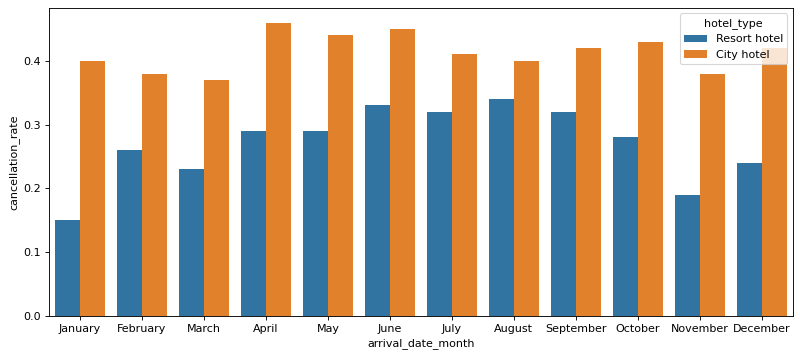

In [29]:
hotel_month = hotel_cancel(cg_data, 'arrival_date_month')
sns.set_context({'figure.figsize': [12,5]})
sns.barplot(x = 'arrival_date_month', y = "cancellation_rate" , hue="hotel_type", data = hotel_month, order = month_name_list)

City Hotel has higher cancellation rates than Resort Hotel throughout the year, and there is no clear trend in monthly cancellation rates. On the other hand, Resort Hotel has a higher cancellation rate in June, July, August and September, compared to the beginning and end of the year.

**Meal Type**

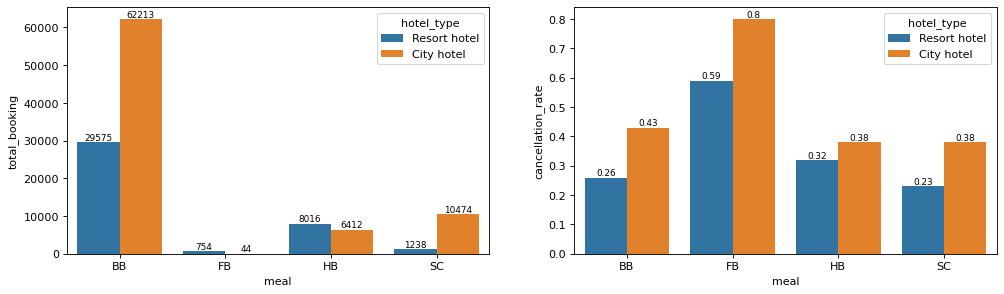

In [30]:
hotel_meal = hotel_cancel(cg_data, 'meal')
fig = plt.figure(figsize=(15, 4))
fig.add_subplot(1, 2, 1)
ax1 = sns.barplot(x = 'meal', y = 'total_booking' , hue = 'hotel_type', data = hotel_meal)
for i in ax1.containers:
    ax1.bar_label(i, fontsize = 8)
fig.add_subplot(1, 2, 2)
ax2 = sns.barplot(x = 'meal', y = 'cancellation_rate' , hue='hotel_type', data = hotel_meal)
for i in ax2.containers:
    ax2.bar_label(i, fontsize = 8)

The graph shows:
* In all `meal` categories, the cancellation rate for City Hotel is higher than that for Resort Hotel. 
* The highest cancellation rates for both type of hotels are found in the Full board (FB) category. However, we can see that the total number of bookings in the Full board (FB) category is very low and thus this result is not considered to be generalised. 
* Except for the Full board (FB) category, bookings with Bed & Breakfast (BB) is the most likely to cancel for City Hotel. For Resort Hotel, it is Half board (HB) that is most likely to have high cancellation rates.

**Country of Origin**

As for the nationality of guests, we prefer to treat the two hotels as a whole, that is, not to discuss the two hotels separately. In fact, even when analyzed separately, the nationality distribution of their guests is similar.

In [35]:
country_c = cancel_by_group(cg_data, 'country')
display(country_c.describe().round(4))

total_booking  cancellation_rate
count       177.0000           177.0000
mean        670.7684             0.3029
std        3922.8794             0.2987
min           1.0000             0.0000
25%           2.0000             0.0000
50%          12.0000             0.2500
75%          74.0000             0.4600
max       48478.0000             1.0000

From the above table, we find that at least 75% of countries have only limited bookings (less than 100). Countries with few bookings will be ignored in later analysis because:
1. With too few data, we can't get a general result for guests with nationality of this country.
2. When running a hotel, we want to focus on main customer groups. Paying much attention to the minority doesn't cost effective.

Meanwhile, we don't want to exclude too many bookings, so the threshold of the least total bookings of one country needs setting carefully. Here, we choose countries with total bookings > 1000 and get 15 countries (see the graph below).

In [36]:
country_c_d = country_c[country_c['total_booking'] > 1000]
print(round(sum(country_c_d['total_booking'])/sum(country_c['total_booking'])*100,2),'%')

90.99 %


These 15 countries account for more than 90% of total bookings.

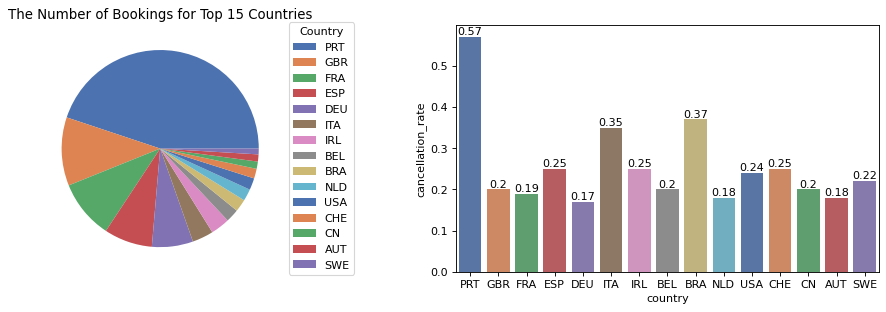

In [33]:
sns.set_context({'figure.figsize': [10,5]})
fig = plt.figure(figsize=(15, 4))
fig.add_subplot(1, 2, 1)
colors = sns.color_palette('deep')
wedges, text = plt.pie(country_c_d['total_booking'], colors = colors)
plt.legend(wedges, country_c_d['country'], title = 'Country', loc = 'center left', bbox_to_anchor = (1, 0, 0.5, 1))
plt.title('The Number of Bookings for Top 15 Countries')
fig.add_subplot(1, 2, 2)
ax = sns.barplot(x = 'country', y = 'cancellation_rate', data = country_c_d, palette = colors)
for i in ax.containers:
    ax.bar_label(i)

The graph shows that
* Portugal (PRT) is the country with the most guests and the highest cancellation rate (57%). We can reasonably speculate that these two hotels are in Portugal, so there are more guests from this country. Moreover, due to the shorter distance or more convenient transportation, it is less costly for Portuguese to change their travel, so the proportion of booking cancellations is higher.
* Italy (ITA) and Brazil (BRA) have relatively high cancellation rate (35% and 37% respectively),and other countries in the top 15 except for Portugal have cancellation rates around 20%.

**Market Segment**

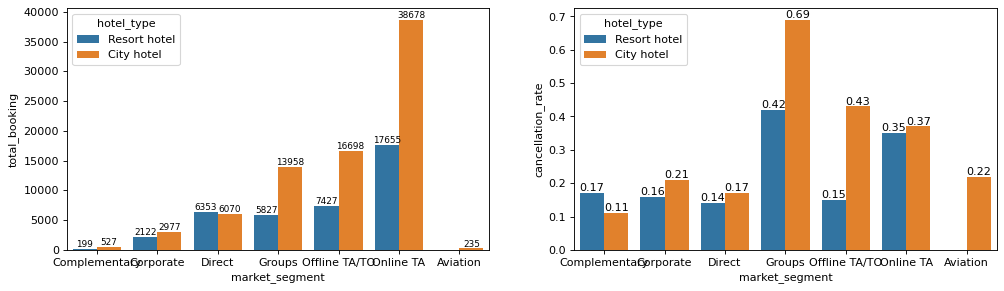

In [20]:
hotel_segment = hotel_cancel(cg_data, 'market_segment')
fig = plt.figure(figsize=(15, 4))
fig.add_subplot(1, 2, 1)
ax1 = sns.barplot(x = 'market_segment', y = 'total_booking' , hue = 'hotel_type', data = hotel_segment)
for i in ax1.containers:
    ax1.bar_label(i, fontsize = 8)
fig.add_subplot(1, 2, 2)
ax2 = sns.barplot(x = 'market_segment', y = 'cancellation_rate' , hue = 'hotel_type', data = hotel_segment)
for i in ax2.containers:
    ax2.bar_label(i)

We observe that
* For total bookings, the majority of customers of both hotels make their bookings through online Travel Agents (TA). Besides, no booking in Resort Hotel belongs to Aviation segment.
* For cancellation rate, in the most `market_segment` categories, City Hotel has higher cancellation rates than Resort Hotel, except in Complementary. Besides, bookings by groups have the highest cancellation rates for both hotels.

**Room Type**

There are two features that provide information about room type, `reserved_room_type` and `assigned_room_type`. We will first explore the relationship between the reserved room types and cancellation rates, and then consider whether assigning the same type of rooms as reservation has a significant influence on the cancellation rate.

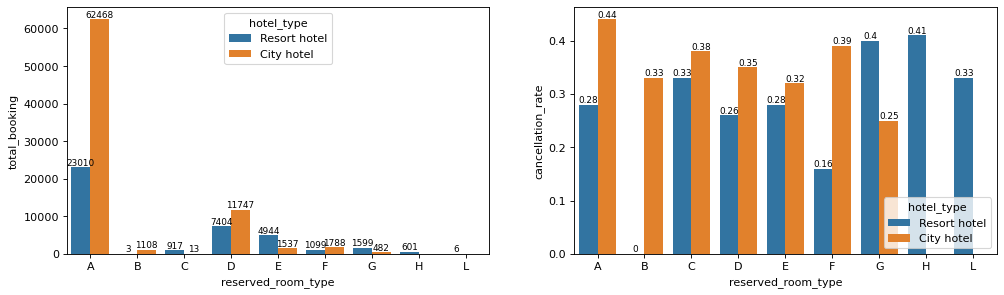

In [35]:
hotel_rm = hotel_cancel(cg_data, 'reserved_room_type')
fig = plt.figure(figsize=(15, 4))
fig.add_subplot(1, 2, 1)
ax1 = sns.barplot(x = 'reserved_room_type', y = 'total_booking' , hue = 'hotel_type', data = hotel_rm)
for i in ax1.containers:
    ax1.bar_label(i, fontsize = 8)
fig.add_subplot(1, 2, 2)
ax2 = sns.barplot(x = 'reserved_room_type', y = 'cancellation_rate' , hue = 'hotel_type', data = hotel_rm)
ax2.legend(loc = 'lower right', title = 'hotel_type')
for i in ax2.containers:
    ax2.bar_label(i, fontsize = 8)

From the graph, we can tell:
* The room type reserved by most guests of both Resort Hotel and City Hotel is Type A. Many types only have few bookings such as type B in Resort Hotel and Type C in City Hotel. Besides, we speculate that the room types of the two hotels are not the same, since there is no bookings of type H and L in City Hotel.
* Due to the small number of bookings in many types of rooms, the detailed analysis of cancellation rate for each type in each hotel is lack of need. If we see the cancellation rates for type A (28% in Resort Hotel and 44% in City Hotel), we can find that they are close to the cancellation rate for the whole hotel (28% and 42% respectively). 

Now we want to find whether assigning the same type of rooms as reservation has any influence on the cancellation rate. We add a new column `same_room_type` into our data, which represents whether the assigned room type is same as the reserved room type.

In [36]:
cg_data['same_room_type'] = cg_data['reserved_room_type'] == cg_data['assigned_room_type']

In [37]:
hotel_cancel(cg_data, 'same_room_type')

same_room_type  total_booking  cancellation_rate    hotel_type
0           False           7499               0.05  Resort hotel
1            True          32084               0.33  Resort hotel
2           False           7078               0.06    City hotel
3            True          72065               0.45    City hotel

From the result, we can see that for both hotels, assigning different type of rooms will result in a much lower cancellation rate. Recalling our own experience in hotels, if the hotels change our reserved room type, it is common that they upgrade the room for us. At the same price, everyone will be willing to enjoy better rooms. This may be the reason behind the low cancellation rate.

**Deposit Type**

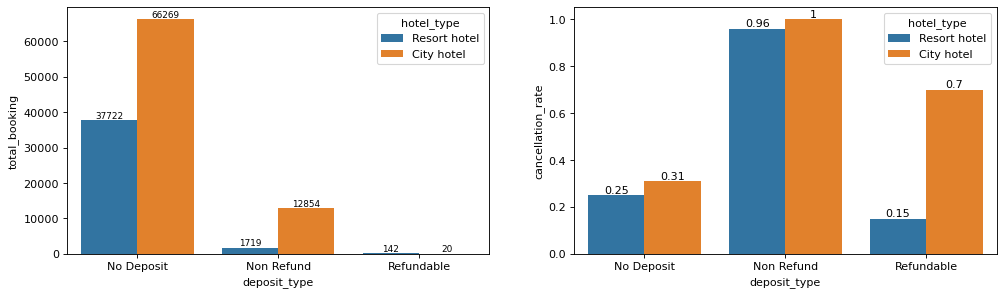

In [38]:
hotel_deposit = hotel_cancel(cg_data, 'deposit_type')
fig = plt.figure(figsize=(15, 4))
fig.add_subplot(1, 2, 1)
ax1 = sns.barplot(x = 'deposit_type', y = 'total_booking' , hue = 'hotel_type', data = hotel_deposit)
for i in ax1.containers:
    ax1.bar_label(i, fontsize = 8)
fig.add_subplot(1, 2, 2)
ax2 = sns.barplot(x = 'deposit_type', y = 'cancellation_rate' , hue = 'hotel_type', data = hotel_deposit)
for i in ax2.containers:
    ax2.bar_label(i)

From the graph, we can see that City Hotel has a high cancellation rate (70%) in refundable bookings, but as the total number of such bookings is so small (only 20 bookings) that we don't have to worry about it.

A more serious thing is that the cancellation rate for non-refundable bookings is the highest. Resort Hotel has 96% cancellation rate in 1719 non-refundable bookings and City Hotel has nearly 100% cancellation rate in more than 12000 non-refundable bookings, which is counter-intuitive. We next want to explain it using our data.

In [39]:
data_deposit = d.groupby('deposit_type').mean()
data_deposit.drop(['arrival_date_year','arrival_date_week_number','arrival_date_day_of_month'], axis = 1, inplace = True)
display(data_deposit.T.round(4))

/var/folders/y5/hx36dcps0wj9r1hxwq1x3zj80000gn/T/ipykernel_61359/746677372.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_deposit = d.groupby('deposit_type').mean()


deposit_type                    No Deposit  Non Refund  Refundable
is_canceled                         0.2849      0.9936      0.2222
lead_time                          89.1175    212.9280    152.0988
stays_in_weekend_nights             0.9711      0.6223      0.9753
stays_in_week_nights                2.5579      2.0902      2.8519
adults                              1.8680      1.8112      1.9074
children                            0.1190      0.0006      0.0309
babies                              0.0091      0.0000      0.0000
is_repeated_guest                   0.0354      0.0044      0.0247
previous_cancellations              0.0418      0.4119      0.0000
previous_bookings_not_canceled      0.1487      0.0106      0.0185
booking_changes                     0.2471      0.0125      0.5926
days_in_waiting_list                1.5249      7.9999      9.5864
adr                               103.8768     89.9880     76.2098
required_car_parking_spaces         0.0705      0.0001      0.1235
total_of_special_requests           0.6523      0.0018      0.1420

Calculating all mean values of the data grouped by deposit type, we can see:
* On average, non-refundable bookings have a longer `lead_time`, but a shorter length of stay.
* Non-refundable bookings have a lower average number of children and babies.
* Non-refundable bookings have a low average rate of repeated guests (0.44%), but once they are repeated guests, the average number of cancellations of their previous orders is high.
* Non-refundable bookings tend to have fewer special needs and demand for car parking spaces. And the average number of changes made to an order after it has been entered on the PMS is only 0.012, which is very low.

Based on the above findings, we guess that these non-refundable bookings are made for business trips. And the nature of business trips result in a high cancellation rate. In more detail, for a business trip, all preparations will be done far in advance, and in consideration of saving money, non-refundable reservation which is very likely to be cheaper will be chosen. But at the same time, it is also subject to changes of circumstances, which will lead to cancellation. Next we want to see whether this guess is tenable.

In [40]:
nonrefund = cg_data[cg_data['deposit_type'] == 'Non Refund']
len(nonrefund)

14573

In [41]:
nonrefund[nonrefund['company'] != '0'].shape

(506, 14)

It shows that only a small percentage (506/14573) of non-returnable orders are made by companies, so it cannot verify our guess and this nearly to 1 cancellation rate for non-refundable bookings is still strange. We consider to exclude `deposit_type` from our model.

**Agent and Company**

For `agent` and `company`, we deal with them similar to what we have done for `country`. There are too many agencies and companies in our data and we are only interested in those with large number of total bookings.

Firstly, we focus on `agent`.

In [37]:
hotel_agent = hotel_cancel(cg_data, 'agent')
hotel_agent.describe()

total_booking  cancellation_rate
count     409.000000         409.000000
mean      290.283619           0.241809
std      1863.786785           0.312919
min         1.000000           0.000000
25%         2.000000           0.000000
50%        19.000000           0.100000
75%        76.000000           0.390000
max     31915.000000           1.000000

We can see from the above table that more than 75% of agencies only have less than 100 bookings. We set a threshold at 500.

In [38]:
hotel_agent_d = hotel_agent[hotel_agent['total_booking'] > 500]
print('There are', len(hotel_agent_d['agent'].drop_duplicates()), 'agencies that have more than 500 bookings in one hotel,')
print('and they take up of', round(sum(hotel_agent_d['total_booking'])/sum(hotel_agent['total_booking'])*100, 2),'%',
      'bookings in all bookings of these two hotels.')

There are 26 agencies that have more than 500 bookings in one hotel,
and they take up of 83.2 % bookings in all bookings of these two hotels.


Then we only look at these 26 agencies. Notice that 0 means that the bookings are not made by agents.

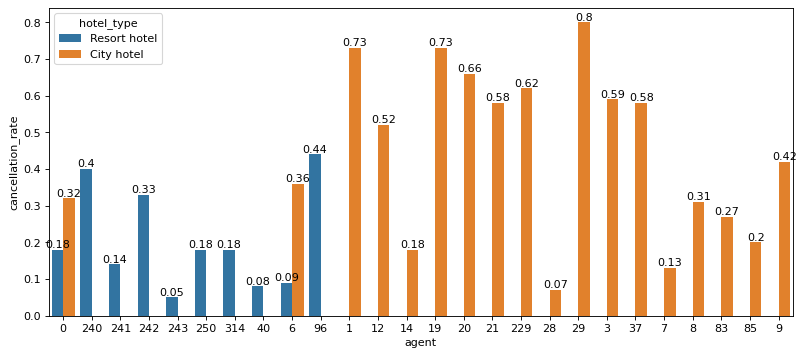

In [44]:
sns.set_context({'figure.figsize': [12,5]})
ax = sns.barplot(x = 'agent', y = 'cancellation_rate' , hue='hotel_type', data = hotel_agent_d)
for i in ax.containers:
    ax.bar_label(i)

The graph tells:
* Most agencies have their preference between the two hotels when making reservations. Or we can say that most agencies make reservations mostly in only one of the two hotels. It can be regarded as the partnerships between agencies and hotels.
* There are 17 agencies having more than 500 bookings in City Hotel and 9 agencies in Resort Hotel, from which we can also infer that City Hotel has larger number of bookings than Resort Hotel.

Similarly, we look at `company`.

In [45]:
hotel_cancel(cg_data, 'company').sort_values(by = ['total_booking'], ascending = False).head(6)

company  total_booking  cancellation_rate    hotel_type
233       0          75477               0.43    City hotel
0         0          36645               0.29  Resort hotel
371      40            921               0.08    City hotel
43      223            784               0.15  Resort hotel
422      67            267               0.66    City hotel
397      45            249               0.11    City hotel

Most bookings (112122/118726) are not made by companies. For modeling, we can take company 40 and company 223 into consideration, since they are the only two that have relatively large total bookings and significantly low cancellation rate compared to those bookings not made by companies.

### 2.2 Feature Engineering

#### 2.2.1 Features Added
Just as we analysed before, we will add one feature `same_room_type`, where 1 represents that the assigned room type is same as the reserved room type and 0 represents different room types between reservation and assignment.

In [56]:
d['same_room_type'] = (cg_data['reserved_room_type'] == cg_data['assigned_room_type']).astype(int)

#### 2.2.2 Features Eliminated
* We will eliminate `assigned_room_type`, since it can be effectively represented by our new feature `same_room_type`.
* We will eliminate `deposit_type` because of the possible wrong data based on our analysis before.
    - We found ~100% of the non-refundable deposit type had cancelled their bookings. Objectively, this is a very strange occurence so we expect the data here is wrong. Additionally, this section represents a large chunk of the data, so cannot trust the accuracy of the data collection here.
* We will eliminate `arrival_date_week_number` and `arrival_date_year` because:
  1. The week of the arrival date can be fully represented by the month and the day of the arrival date. The latter two are more intuitive and already contained in our data.
  2. The years of our data are too far away from the present. What we want to do is the prediction of future cancellation, so it is not meaningful to contain the year of the arrival date in our model.
* We will eliminate `arrival_date_day_of_month`, since we think day of month of arrival date should not have an impact on whether  a booking will be cancelled.

In [57]:
d = d.drop(columns = ['assigned_room_type', 'deposit_type', 
                      'arrival_date_week_number', 'arrival_date_year', 'arrival_date_day_of_month'])

#### 2.2.3 Features Encoded

For `arrrival_date_month`, we use 1-12 to replace January to December.

In [58]:
d.replace(month_name_list, month_num_list, inplace = True)

For `country`, `agent`, and `company`, we only take categories with large number of bookings into consideration. In more details, we pick up countries with more than 1000 bookings, agents with more than 500 bookings and companies with more than 500 bookings.

In [59]:
country_list = country_c_d['country'].values

# perform encoding on the country column
encoded = pd.get_dummies(d['country'].apply(lambda x: x if x in country_list else 'Other_country'))

# merge the encoded dataframe with the original dataframe
d = pd.concat([d, encoded], axis = 1)

# drop the original country column and the Other_country since it is indirectly encoded in the other columns"""
d.drop(['country', 'Other_country'], axis = 1, inplace = True)

In [60]:
# get a list of agents so we can encode the agents columns
agent_list = hotel_agent_d['agent'].drop_duplicates().values
# encode them
encoded = pd.get_dummies(d['agent'].apply(lambda x: x if x in agent_list else 'Other_agent'))
# and add them to our dataframe
d = pd.concat([d, encoded], axis = 1)
# then drop the old columns
d.drop(['agent', 'Other_agent'], axis = 1, inplace = True)

In [61]:
# do the same but for the companies
company_list = ['0', '40', '223']
encoded = pd.get_dummies(d['company'].apply(lambda x: x if x in company_list else 'Other_company'))

# rename the company ID, in order to tell them apart from agent ID
encoded = encoded.rename(columns={'0': '0(company)', '40': '40(company)', '223': '223(company)'})

# and drop the old columns
d = pd.concat([d, encoded], axis = 1)
d.drop(['company', 'Other_company'], axis = 1, inplace = True)

The data after encoding these three features is shown as follows.

In [62]:
d.iloc[0:1, -40:]

CN  DEU  ESP  FRA  GBR  IRL  ITA  NLD  PRT  SWE  ...  6  7  8  83  85  9  \
0   0    0    0    0    0    0    0    0    1    0  ...  0  0  0   0   0  0   

   96  0(company)  223(company)  40(company)  
0   0           1             0            0  

[1 rows x 40 columns]

Remember that we have 12 categorical features. After deleting 2 and encoding the above 4, there are still 6 features. They all have limited (less than 10) catogories, so we directly use OneHotEncode.

In [63]:
# get a list of our features to encode
onehot_feature = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'customer_type']

# get column index of onehot_features in our data
onehot_column = []
for feature in onehot_feature:
    onehot_column.append(d.columns.get_loc(feature))
    
# get column index of other features
all_column = list(range(0, d.shape[1]))
others_column = list(set(all_column) - set(onehot_column))

In [64]:
# set drop = 'first': drop the first category in each feature. 
# "If only one category is present, the feature will be dropped entirely."
ONE = OneHotEncoder(drop = 'first')

# set up the encode
encoder = ColumnTransformer([
    ('others', 'passthrough', others_column),
    ('onehot', ONE, onehot_column),
])
# and encode it
d = encoder.fit_transform(d)

In [65]:
# get features' names after encoded
column_names = encoder.get_feature_names_out()
for i in range(len(column_names)):
    column_names[i] = column_names[i][8:]

In [66]:
# the data used to build the model
d = pd.DataFrame(d, columns = column_names)
d.shape

(118726, 85)

That concludes the EDA, data cleaning and feature engineering. We can now move on to the model fitting and tuning!

## 3. Model Fitting and Tuning

The structure of this section is as follows:

1) We will split the data in to testing and training.
2) We will briefly show the comparison of 3 different (already hypertuned) models: We will move on with the Logistic Regression.
3) We show the hypertuning of the logistic Regression model parameters. 
4) We find the most important features of the model
5) We discuss how setting a threshold for the predictions can help reach business goals. 

### So what is our final model?
Our final model is a Logistic Regression classifier. 

#### Models we have tried but will not continue with:

* Linear and Ridge Classification
    * Bad choices for the model and their performance reflected this.
* Decision Tree Classifier
    * This is due to the lower ROC AUC score (as seen below).
* K nearest neighbours
    * It is a black box model. Additionally, its performance was not as good.
* SVC classifier 
    * It is too computationally expensive to run on our large dataset.
* Random Forest
    * It is also a Black box, but was useful for comparing performance during testing.

We will very briefly demonstrate below why we settled for the logistic regression model.


### Target Variable 

In this project the target variable `is_canceled` is either 1 if a customer cancels their booking or 0 if they do not cancel their hotel booking. There are four possible outcomes for our classification model:
* True Positive (TP): The booking is canceled (1) and the model also predicts that the booking will be canceled (1)
* True Negative (TN): The booking is NOT canceled (0) and the model correctly predicts that the booking will NOT be canceled (0)
* False Positive (FP): The booking is NOT canceled (0) but the model wrongly predicts that the booking will be canceled (1)
* False Negative (FN): The booking is canceled (1) but the model wrongly predicts that the booking will NOT be canceled (0)



### Splitting and scaling our data

From the EDA, we could see the data allows us to scale it using the StandardScaler from sklearn.

In [57]:
# Split the dataset into features (X) and target (y)
X = data.drop('is_canceled', axis=1)
y = data['is_canceled']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a preprocessor for scaling and normalizing data
scalar = StandardScaler()

# Preprocess the training data
X_train_preprocessed = scalar.fit_transform(X_train)
X_test_preprocessed = scalar.transform(X_test)


### Now we briefly demonstrate why we used Logistic Regression over others

We also quickly explain our reasoning behind choosing the model. We want to ideally minimize the positive and negative classes. The reasoning is further developed later on but the idea is that the client might have varying business goals. If avoiding overbooking is their goal (they might be a small hotel), then they would like to reduce false positives. However, if they dont mind overbooking (maybe they have a lot of empty extra rooms), then they would prefer false positives over false negatives. Therefore, choosing a model that can balance both is important for the flexibility of the client. Additionally, manually changing a threshold for the prediction classification is allowed with Logistic Regression and not with the otherwise superior candidate: Decision Tree. Therefore below we demonstrate that the Logistic Regression is the best model for the client's needs.

The metrics we will use to evaluate our models are defined as follows:

* Accuracy - Total accuracy of the model. How many identifications or classifications are correct as a percentage of the total number of samples. This is the sum of TP and TN over the total. 

* Specificity : The total coverage of true negatives. It is defined as the model estimate of true negatives (TN) over the total true number of negatives (TN + FP)

* Recall: Also known as the true positive rate. It is defined as the number of true positive (TP) estimates over the total number of true positive samples (TP+FN). 

* FPR: The false positive rate is defined as the total number of false positives (FP) over the total number of true negatives in the dataset (FP+TN)

* Precision: The accuracy of the true positive predictions. It is defined as the true positive estimates TP divided by the sum of the false positives (FP) and the true positives (TP)

* ROC AUC: Quantifies the performance of the classifier by calculating the area under the ROC curve. An AUC of 1 indicates a prefect model and an AUC of 0.5 indicates a random model. 

Logistic Regression (C=10) Performance Metrics:
  Specificity: 0.89
  Recall: 0.73
  F1 score: 0.76
  Precision: 0.79
  ROC AUC: 0.90
  Total accuracy: 0.83

Decision Tree Performance Metrics:
  Specificity: 0.89
  Recall: 0.82
  F1 score: 0.81
  Precision: 0.81
  ROC AUC: 0.85
  Total accuracy: 0.86



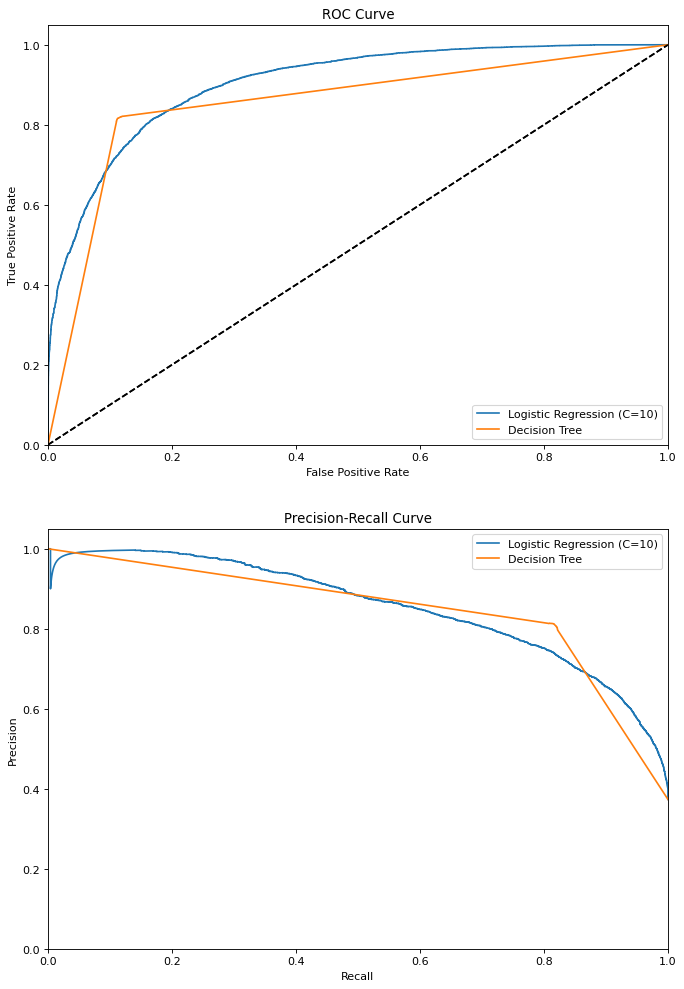

In [58]:
# Define three different classification models with different hyperparameters
# We only want glass box models - random forest is hence not suitable
models = [
    ('Logistic Regression (C=10)', LogisticRegression(solver = 'liblinear',C=10)),
    ('Decision Tree', DecisionTreeClassifier()), 
   #('NN', KNeighborsClassifier())                  - it's a black box
   #('SVC', SVC(kernel='linear', probability=True)) - too expensive to run
]

fig, [ax1,ax2] = plt.subplots(2,1, figsize=[10,15])

for name, model in models:
    #fit the model
    model.fit(X_train_preprocessed, y_train)

    #predict probabilities for the test set
    y_pred_proba = model.predict_proba(X_test_preprocessed)[:, 1]

    #calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    #plot ROC curve
    ax1.plot(fpr, tpr, label=name)
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend(loc="lower right")

    #calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

    #plot it
    ax2.plot(recall, precision, label=name)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')

    #calculate performance metrics
    y_pred = model.predict(X_test_preprocessed)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = (tp+tn)/(tp+tn+fn+fp)

    #print the results
    print(f'{name} Performance Metrics:')
    print(f'  Specificity: {specificity:.2f}')
    print(f'  Recall: {recall:.2f}')
    print(f'  F1 score: {f1:.2f}')
    print(f'  Precision: {precision:.2f}')
    print(f'  ROC AUC: {roc_auc:.2f}')
    print(f'  Total accuracy: {accuracy:.2f}\n')
    
plt.legend()
plt.show()


The main feature we are looking for is the ROC AUC, as mentioned above. We can see the Logistic Regression has 5% more AUC which substantially higher. The random forest does have a slightly higher accuracy, which can also be seen in the other test statistics. However, we will demonstrate that the logistic regression model allows for a higher degree of felxibility for the clients' business goals, which outweighs the marginal detriments. 

## Optimizing the Logistic Regression Model

We show here the optimal C parameter for the logistic regression. The C parameter determines the regularization strength by adding a penalty term to the loss function. We vary over several factors of 10 to find the optimal value. 

The solver we use is liblinear. This is because it is designed for large datasets with many features, and supports us testing l1 and l2 regularization. Other solvers produced errors or took too long to converge. 

In [59]:
# Define the models and their parameters for grid search
# we tried using other solvers but their fits would fail or take too long
params = [{'solver': ['liblinear'], 'C': [0.001,0.01,0.1, 1, 10], 'penalty' : ['l1', 'l2']}]

# K-fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# define my model
model = LogisticRegression()

# Perform GridSearchCV for the Tree model and compare their performance
grid = GridSearchCV(estimator= model, param_grid=params, scoring='accuracy', cv=kfold)
grid.fit(X_train_preprocessed, y_train)

best_params = grid.best_params_
best_score = grid.best_score_

# Test the model with the best parameters found by GridSearchCV
best_model = model.set_params(**best_params)
best_model.fit(X_train_preprocessed, y_train)
y_pred = best_model.predict(X_test_preprocessed)
test_accuracy = accuracy_score(y_test, y_pred)

print('Logistic Regression')
print(f'  Best parameters: {best_params}')
print(f'  Best cross-validation score: {best_score:.4f}')
print(f'  Test accuracy: {test_accuracy:.4f}')

Logistic Regression
  Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
  Best cross-validation score: 0.8236
  Test accuracy: 0.8269


We can see that the best parameter is C = 10 with an l1 penalty. It gives us a cross validation score very similar to the testing score: so we can conclude it has generalized to the features very well. 

Next up, we want to see how the model ranks each feature. There are a lot of features and most are irrelevant. So we see what matters most for predicting the cancellation rate:

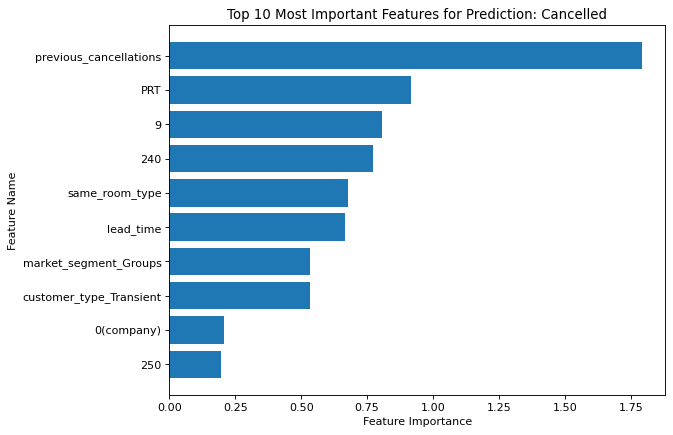

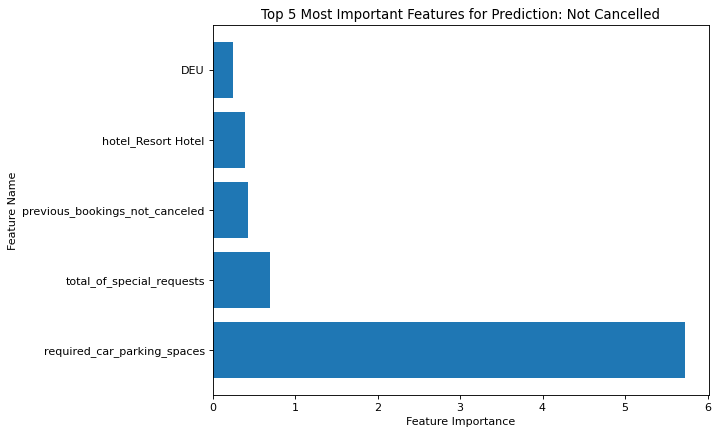

In [60]:
# fit a logistic regression model
lr = LogisticRegression(solver = 'liblinear',C=10, penalty='l1')
lr.fit(X_train_preprocessed, y_train)

# calculate feature importances
importance = lr.coef_[0]
indices = np.argsort(importance)

# plot the 10 most important features
plt.figure(figsize=(8, 6))
plt.barh(range(10), importance[indices[-10:]])
plt.yticks(range(10), X.columns[indices[-10:]])
plt.title('Top 10 Most Important Features for Prediction: Cancelled')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')

# plot the 10 least important features
plt.figure(figsize=(8, 6))
plt.barh(range(5), abs(importance[indices[:5]]))
plt.yticks(range(5), X.columns[indices[:5]])
plt.title('Top 5 Most Important Features for Prediction: Not Cancelled')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')

plt.show()

One of the most important feature for cancellation, it is whether people are from Portugal. This is where we might need to talk about AI **ethics**.
* Our model is clearly learning that people from Portugal are more likely to cancel their bookings. Applying this blindly, we would have advised the hotel to possibly put Portugese guests at a booking disadvantage. However, ethically, it is not justifiable to discriminate an entire countries citizens to different booking standards just because of what the model learned. The next cell in this notebook will show what happens if we ignore the countries as a feature.

#### What are the most important features if we drop the countries column? 

We want to do this to avoid discrimination. So lets compare how our results change. First we hypertune the model again:

In [79]:
# Define the models and their parameters for grid search
# we tried using other solvers but their fits would fail or take too long
params = [{'solver': ['liblinear'], 'C': [0.001,0.01,0.1, 1, 10], 'penalty' : ['l1', 'l2']}]

# K-fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# define my model
model = LogisticRegression()

# Perform GridSearchCV for the Tree model and compare their performance
grid = GridSearchCV(estimator= model, param_grid=params, scoring='accuracy', cv=kfold)
grid.fit(X_train_withoutCountries_preprocessed, y_train)

best_params = grid.best_params_
best_score = grid.best_score_

# Test the model with the best parameters found by GridSearchCV
best_model = model.set_params(**best_params)
best_model.fit(X_train_withoutCountries_preprocessed, y_train)
y_pred = best_model.predict(X_test_withoutCountries_preprocessed)
test_accuracy = accuracy_score(y_test, y_pred)

print('Logistic Regression')
print(f'  Best parameters: {best_params}')
print(f'  Best cross-validation score: {best_score:.4f}')
print(f'  Test accuracy: {test_accuracy:.4f}')

Logistic Regression
  Best parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
  Best cross-validation score: 0.8035
  Test accuracy: 0.8033


We will use these parameters to see the feature importances:

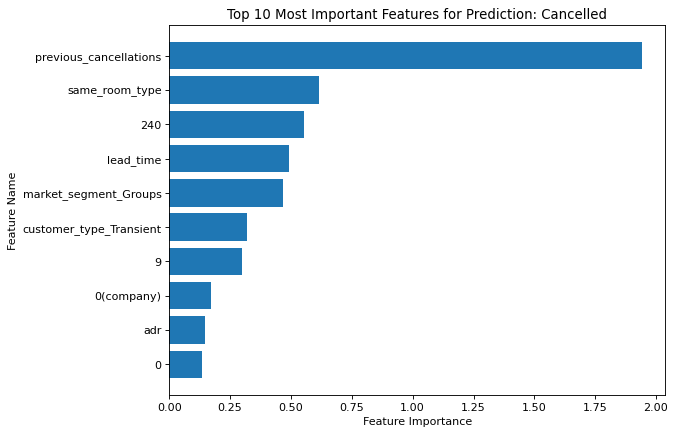

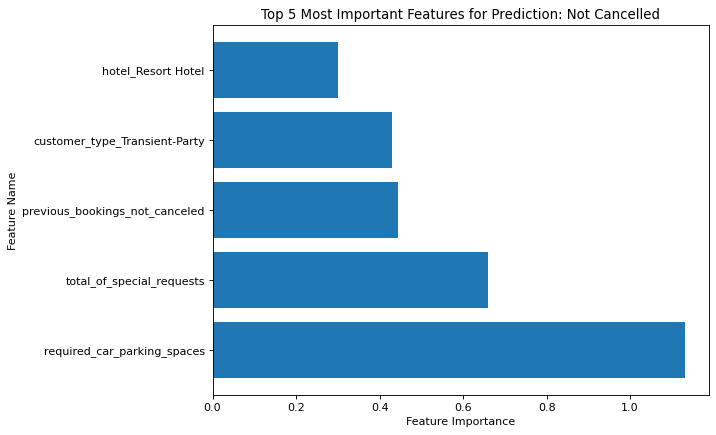

In [88]:
# we list all the encoded countries
countries = ['AUT', 'BEL', 'BRA','CHE', 'CN', 'DEU', 'ESP', 'FRA', 'GBR', 'IRL', 'ITA', 'NLD', 'PRT','SWE', 'USA']
# and remove them
X_train_withoutCountries = X_train.drop(countries, axis =1)
X_test_withoutCountries = X_test.drop(countries, axis =1)
X_train_withoutCountries_preprocessed = scalar.fit_transform(X_train_withoutCountries)
X_test_withoutCountries_preprocessed = scalar.fit_transform(X_test_withoutCountries)

# fit a logistic regression model
lr = LogisticRegression(solver = 'liblinear',C=0.01, penalty='l1')
lr.fit(X_train_withoutCountries_preprocessed, y_train)

# calculate feature importances
importance = lr.coef_[0]
indices = np.argsort(importance)

# plot the 10 most important features
plt.figure(figsize=(8, 6))
plt.barh(range(10), importance[indices[-10:]])
plt.yticks(range(10), X_train_withoutCountries.columns[indices[-10:]])
plt.title('Top 10 Most Important Features for Prediction: Cancelled')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')

# plot the 5 least important features
plt.figure(figsize=(8, 6))
plt.barh(range(5), abs(importance[indices[:5]]))
plt.yticks(range(5), X_train_withoutCountries.columns[indices[:5]])
plt.title('Top 5 Most Important Features for Prediction: Not Cancelled')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')

plt.show()

We already see some important things:

* For the most important feautre for cancellation, it is the previous cancellations. We had already seen this hinted in in the EDA section, and it still makes sense since people who have cancelled before are more likely to cancel again!
* Other important features for cancellations are 9 and 240 (these are the agent IDs)! This is important because it shows some agents are more responsible for cancellations!
* Market Segment and lead time are also very important for our model, which again we also saw hinted at in the EDA section!
* Our engineered feature: same_room_type is also very important: this is where 1 represents that the assigned room type is same as the reserved room type and 0 represents different room types between reservation and assignment. This is not very intuitive. It implies not changing the allocated room leads to cancellations. More on this in the discussion.
* `Lead_time` is also an important feature, which we had also spotted in EDA. This is good news since it makes our model explainable, predictable and transparent.
* Also important to consider is what variables are most likely to produce a prediction of "not cancelled"? We see that the top two here are required car parking spaces and total number of special requests. The special requests makes intuitive sense: booking a hotel and putting in the effort to make special arrangements for your arrival or stay implies you are commited to going. The required car parking spaces does not make intuitive sense: our best guess is a required car parking space implies the guest has already booked a car with a car rental agency, and so is more unlikely to cancel both a hotel since they also have a car rental. 
    * The `required car parking spaces` feature is worrying important compared to the other features. We have no concrete reasoning to believe this is an anomaly so we will not remove it. 
    
It is nice to see that a lot of the most important features we already expected from our EDA. This implies our model is very predictable and understandable!

Let us now see how the accuracy stats change for our new model:

In [83]:
# get the True positive/negative, False positive/negative's and their stats
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = (tp+tn)/(tp+tn+fn+fp)

#print the results
print('Without Contries Logistic Regression Classifier Performance Metrics:')
print(f'  Specificity: {specificity:.2f}')
print(f'  Recall: {recall:.2f}')
print(f'  F1 score: {f1:.2f}')
print(f'  Precision: {precision:.2f}')
print(f'  ROC AUC: {roc_auc:.2f}')
print(f'  Total accuracy: {accuracy:.2f}\n')

Without Contries Logistic Regression Classifier Performance Metrics:
  Specificity: 0.88
  Recall: 0.67
  F1 score: 0.72
  Precision: 0.77
  ROC AUC: 0.85
  Total accuracy: 0.80



As expected, the scores dropped across the board. However, only marginal decreases which is a fair tradeoff to have a non-discriminatory model. For the following section, we will keep using the model without countries!

### Setting a Threshold

Now that our model can produce predictions, we can also decide the threshold to set for the prediction to result in either a positive or negative outcome (cancelled or not). The default threshold often used is 0.5. If it is above this number round it to 1 (True) and if its below, round it to 0 (False). However, it is possible to vary this threshold: this will shift the number of false positives, false negatives, true postitives and true negatives. Shifting this threshold can help the hotel manager achieve specific business goals it has set. 

Let us now put in some thought into the real world impact of varying the threshold:

**False Positive** <br>
An FP result indicates that the model predicts a particular booking will be canceled when in reality it will not be canceled. The impact on the hotel is that this might lead to overbooking, since it might open a room for booking when it predicts it will be cancelled. This can become very problematic if the hotel reaches full capacity for a night and has to turn away guests. Economically this can lead to (1) loss through extra compensation for the guests turned away which may even exceed the cost of the room (2) Loss of reputation which in turn may lead to loss of sales in the future. 

**False Negative** <br>
An FN results indicates that the model predicts that a booking will be NOT be canceled when in reality it will indeed be canceled. For the hotel, a high FN rate can be devastating as it may lead to many empty rooms on any given night. This implies losses for the hotel in terms of the revenue lost from having empty rooms and not reaching full capacity. The economic loss also depends on whether a deposit was paid and the value of that deposit. 



First, let us see what it looks like for the default value: 0.5:

<i> Note that we are still using the training dataset since we are tuning our model threshold here.

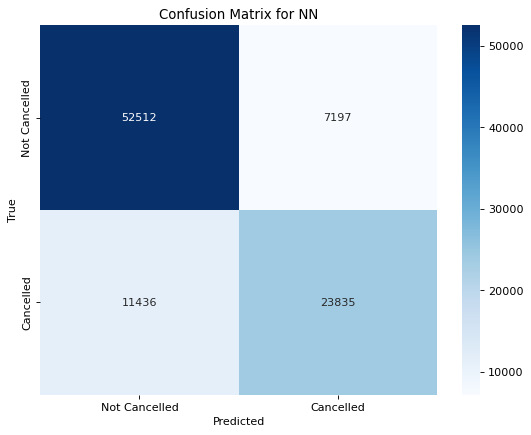

In [84]:
model = LogisticRegression(solver = 'liblinear', C=0.1, penalty='l1').fit(X_train_withoutCountries_preprocessed, y_train)
y_pred_proba = model.predict_proba(X_train_withoutCountries_preprocessed)[:, 1]

# Apply a custom threshold to make predictions
threshold = 0.5
y_pred_custom_threshold = (y_pred_proba >= threshold).astype(int)

labels = ['Not Cancelled','Cancelled']

# Calculate the confusion matrix using the custom threshold predictions
cm = confusion_matrix(y_train, y_pred_custom_threshold)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for NN')
plt.show()

It is important to define what the components of the confusion matrix are in the context of our hotel classification problem. 

The matrix is represented as follows:

| TN | FP |
| -- | -- |
| FN | TN |



Now we can apply the same code to get a graph of by varying the threshold:

In [85]:
# make empty lists to append the False negtive and positive values in 
FN = []
FP = []
for i in np.linspace(0,1,100):
    # Apply a custom threshold to make predictions
    threshold = i # change the variable over i
    y_pred_custom_threshold = (y_pred_proba >= threshold).astype(int)

    # Calculate the confusion matrix using the custom threshold predictions
    # still use only train
    cm = confusion_matrix(y_train, y_pred_custom_threshold)
    FN.append(cm[0,1]/cm.sum())
    FP.append(cm[1,0]/cm.sum())

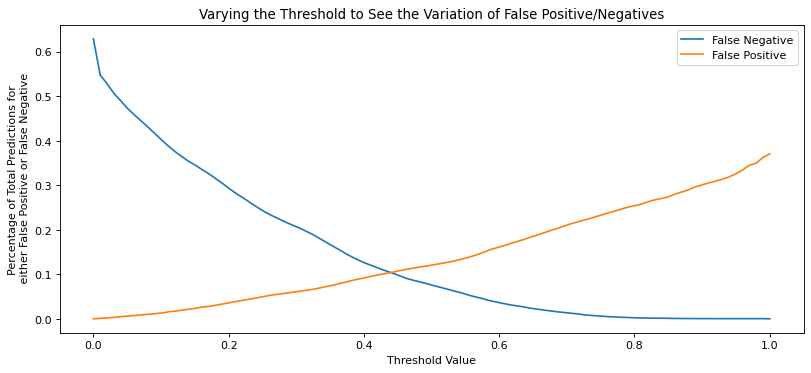

In [86]:
# and start plotting it
plt.plot(np.linspace(0,1,100), FN, label = 'False Negative')
plt.plot(np.linspace(0,1,100), FP, label = 'False Positive')
plt.ylabel('Percentage of Total Predictions for\n either False Positive or False Negative')
plt.xlabel('Threshold Value')
plt.title('Varying the Threshold to See the Variation of False Positive/Negatives')
plt.legend()
plt.show()

This graph shows us how the false positive/negative percentage changes for a given threshold. This is important to show to the hotel manager since it allows a more business oriented approach: choosing lower threshold values might result in overbooking a room, while higher threshold might lead to more empty rooms. 

Now lets us see what the total wrong prediction percentage is with respect to the threshold and what the "opitmal" values are for our training data.

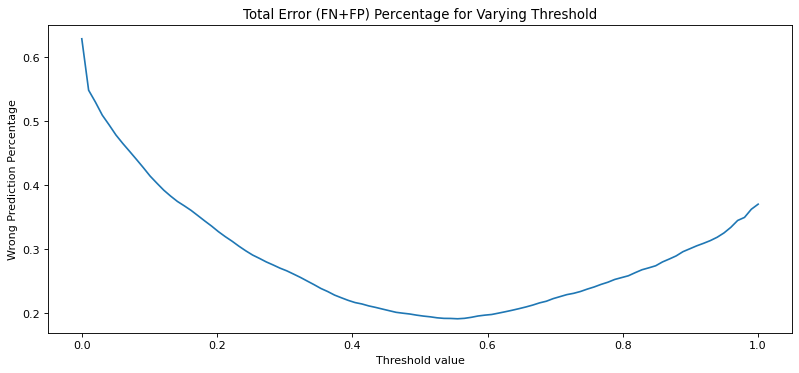

Minimum value at: Threshold = 0.55
Accuracy at minimum:  0.809
False positive percentage:  0.1385


In [87]:
# plot the percentage of total wrong points
plt.plot(np.linspace(0,1,100), [FN[i]+ FP[i] for i in range(100)])
plt.xlabel("Threshold value")
plt.ylabel("Wrong Prediction Percentage")
plt.title("Total Error (FN+FP) Percentage for Varying Threshold")
plt.show()
# and finally get the relevant minimum values and print them below the graph:
print("Minimum value at: Threshold =", np.array([FN[i]+ FP[i] for i in range(100)]).argmin()/100)
print("Accuracy at minimum: ", round(1-np.array([FN[i]+ FP[i] for i in range(100)]).min(),3))
print("False positive percentage: ", round(FP[np.array([FN[i]+ FP[i] for i in range(100)]).argmin()], 4))

Fortunately, the threshold is close to the default: 0.5, as expected. This implies that a balanced business approach for the hotel management would be to choose the threshold to be set at 0.55: it would provide the most accurate modelling and least total errors in overbooking and underbooking rooms. 

However, based on the individuals' hotel business goals, the above graphs serve as a guide to see where they would like the threshold at. For example, a small hotel prone to running out of rooms might want to set their threshold at 0.4 to prevent overbooking. 

## 4. Discussion & Conclusions


The aim of this project was to produce an accurate, understandable model to predict the cancellations in hotel booking and examine what features are most important to cancellation.

Our final model was a Logistic Regression model. It has a high testing score (~80%). This means our model has a good predictive power. The cross validation score was very similar, so we know it is not overfit, and instead has generalized well to the data. This is good for the hotel predictions: higher prediction rates minimises the probability of having false negatives or false positives. However the treatment of these FNs and FPs is very important in the economic goals of the hotel business. A Logistic Regression model is an optimal model to use for the task at hand due to to its 'glass box' nature allowing you, the client, to visualise the most important predictors regarding the cancellation of a booking. These are detailed in order of significance below:

1) Previous Cancellations: If a client has previously canceled a booking they are very likely to cancel again
2) same_room_type: Clients receiving a room that they initially booked leads to cancellations. On first inspection this seems strange. However, consider the request to change a booking might imply a more commited guest, since they are essentially making a special request, for which we also see a drop in cancellations for. 
3) Travel Agent 240: If this agent is responsible for bookings, they are also very likely cause for cancellations. 
4) lead_time: Longer times between the date of booking and the date of the booking imply a higher change of cancellation. Opposite is also true: bookings made shorly before the visit are les likely to get cancelled.
5) Market segment groups: Travel Agents and Tour Operators affect the cancellation rate.

While Portugese poeple had such a high weighting in our inital model, we realises that to maintain integrity and follow AI ethics the model should **NOT** to descriminate against specific countries of origin. Therefore in the final model, the country or origin was removed entirely and the model was retrained. 

The importance of variables for customers not likely to cancel their booking was visualised in order of importance. The top three variable with the highest weightings were `required_car_parking_space` followed by `total_of_special_requests` and finally `previous_bookings_not_canceled`. It is clear that a client's past behaviour regarding booking cancellations is very indicative of their future behaviour. Additionally, if a client makes special requests or requires car parkig spaces, it is likely that they will keep their booking. 

Secondly, the treatment of false positives and false negatives using a logistic regression is extremely flexible thanks to the ease of varying the 'threshold' parameter. This is a measure of the leniency of your hotel when predicting whether a booking will be canceled or not. We have found the optimum threshold to be in the 0.4-0.6 range with a minimum at 0.55. This minimum represents the highest total accuracy for the model. 

#### Setting a higher threshold

A higher threshold increases the probability that the model will predict a booking to be cancelled, more false negatives. The impact on your business of setting a higher threshold is that you run the risk of having empty rooms in your hotel however every customer can be assured that their room will not be overbooked. This can be economically devastating as the loss in income from an empty room can be significant even relative to any deposit paid. However, this does maintain happy customers and will not result in stress amongst employees having to fix overbooking situations.

#### Setting a lower threshold

Lower thresholds descrease the probability of predicting a cancelled booking. This can be viewed as taking a more 'strict' approach, as the number of false positives will increase. Here, the hotel will run the risk of overbooking a room at the benfit of the hotel being close to full capacity. The negative economic impact is that the hotel may turn away customers that have double booked, resulting in compensation for the customer that may exceed the value of the room itself. Additionally, there are long-term negatives associated with this option as the reputation of the hotel will likely fall if many customers continue being turned away. 


##### So would we rather have more false negatives or false positives?

The answer to this is difficult to quantify; without additional data such as the the cost of one room, the deposit value and cancellation policies one cannot quantitatively assess the trade-off between having more FPs or FNs. The loss of reputation from overbooking is also not fully quantifiable. Additionally, the answer to this question is very dependent on the business goals of the hotel. Fortunately, the logistic regression model outputs a continuous variable which you can manually set a threshold for. 

To conclude, the model should be used in combination with additional data such as the monetary value of the deposit and consider the long term effects of having a higher or lower threshold. Typically, having close to zero empty rooms at the cost of potential overbookings (lower threshold) may lead to a boost in profit in the short term. Long-term we maintain that the reputation and integrity of the hotel is more important and will directly lead to higher profits if no customer is turned away. 

###### So what is the financial impact of our model?

We conclude that with our ~80% accuracy model, it gives you (the client) more control and understanding of the booking situation going on at your hotel(s). Using our suggestions on what to set the threshold at, and considering the occupacy of the hotel and its business goals, we have suggested various methods to employ our model to better suit your current needs. It can with great accuracy help you avoid the financial damages of booking cancellations and help you be more prepared in future endeavors. 

**Further Improvements:**
- Using a black box model has shown higher accuracy scores. Implementing a neural network or Random Forest can greatly increase the model accuracy. The detriment here is the lack of understanding of how the model works. 
- Obtain datasets with a more equal geographical spread so the model is not reliant on where the customer is from. 
- Use occupancy rates of the hotel to automatically determine the best threshold for the hotel (by minimizing financial damages from overbooking for example)

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from